# `doubleml` with simulated data

First we'll reuse that code to generate a simulated causal dataset

In [32]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import uniform, normal, binomial, choice

import graphviz as gr
import pandas as pd

def simulate(**kwargs):
  """Helper function to simulate and plot a causal function"""
  values = {}
  g = gr.Digraph()
  for k,v in kwargs.items():
    parents = v.__code__.co_varnames
    inputs = {arg: values[arg] for arg in parents}
    values[k] = v(**inputs)
    for p in parents:
        g.edge(p,k)
  data = pd.DataFrame(values)
  return data, g

,age,degree,income
0,39.981605,3,105607.272102
1,63.028572,2,122171.414700
2,54.279758,2,113208.865174
3,48.946339,3,114428.811783
4,31.240746,2,91017.282832


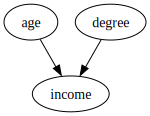

In [44]:
np.random.seed(42)

N = 156

df, g = simulate(
    age = lambda: uniform(25, 65, N),
    degree = lambda: choice(range(4), N),
    income = lambda age, degree: normal(50000 + (1000 * age) + (5000 * degree), 1000)
)
display(df.head())
g

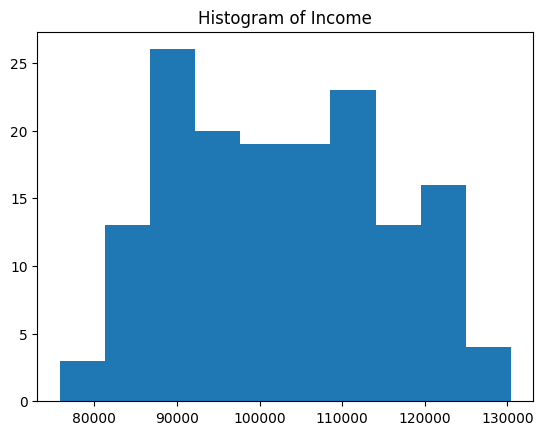

In [45]:
plt.hist(df.income)
plt.title("Histogram of Income");

## Examples with OLS

In [46]:
X = sm.add_constant(df[['age', 'degree']])
y = df['income']

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.309e+04
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          9.40e-172
Time:                        09:06:42   Log-Likelihood:                -1295.0
No. Observations:                 156   AIC:                             2596.
Df Residuals:                     153   BIC:                             2605.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.031e+04    332.695    151.205      0.000    4.96e+04     5.1e+04
age          993.5762      6.651    149.378      0.000     980.436    1006.717
degree      5024.5224     69.119     72.693      0.000    4887.971    5161.074
==============================================================================
Omnibus:                        5.421   Durbin-Watson:                   2.195
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                7.607
Skew:                           0.112   Prob(JB):                       0.0223
Kurtosis:                       4.058   Cond. No.                         193.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this simple case there are no confounders and the simulated coefficients are covered by OLS under these parameters. If we were to increase the error around income our estimate gets worse.

What happens if we omit a variable?

In [47]:
# omitted variable
X = sm.add_constant(df[['age']])
y = df['income']

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     591.5
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.31e-54
Time:                        09:06:42   Log-Likelihood:                -1573.6
No. Observations:                 156   AIC:                             3151.
Df Residuals:                     154   BIC:                             3157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.043e+04   1795.112     33.666      0.000    5.69e+04     6.4e+04
age          958.7688     39.420     24.322      0.000     880.894    1036.643
==============================================================================
Omnibus:                      105.898   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.342
Skew:                          -0.250   Prob(JB):                      0.00209
Kurtosis:                       1.716   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Confounder

,ambition,degree,income
0,0,2,61142.822815
1,1,2,63751.933033
2,0,0,50791.031947
3,0,3,64090.612545
4,0,2,61402.794311


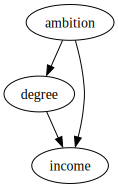

In [48]:
# Simulate dataset in which a confounder exists

np.random.seed(42)

N = 156 # same as previous

df, g = simulate(
    ambition = lambda: choice(range(2), N),
    degree = lambda ambition: choice(range(4), N) + ambition,
    income = lambda degree, ambition: normal(50000 + (5000 * degree) + (3000 * ambition), 1000)
)
display(df.head())
g

In [49]:
# Using OLS we can control for this confounder:
X = sm.add_constant(df[['degree', 'ambition']])
y = df['income']

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     3017.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          1.22e-123
Time:                        09:07:01   Log-Likelihood:                -1303.6
No. Observations:                 156   AIC:                             2613.
Df Residuals:                     153   BIC:                             2622.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.001e+04    173.827    287.684      0.000    4.97e+04    5.04e+04
degree      5094.2246     74.835     68.073      0.000    4946.382    5242.067
ambition    2720.3922    174.794     15.563      0.000    2375.070    3065.714
==============================================================================
Omnibus:                        7.484   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                8.090
Skew:                           0.379   Prob(JB):                       0.0175
Kurtosis:                       3.818   Cond. No.                         6.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
# What happens if we omit the confounder?
X = sm.add_constant(df[['degree']])
y = df['income']

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     2256.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           6.90e-94
Time:                        09:07:09   Log-Likelihood:                -1377.7
No. Observations:                 156   AIC:                             2759.
Df Residuals:                     154   BIC:                             2765.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.076e+04    267.595    189.674      0.000    5.02e+04    5.13e+04
degree      5439.2114    114.504     47.502      0.000    5213.010    5665.413
==============================================================================
Omnibus:                        2.015   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.365   Jarque-Bera (JB):                2.028
Skew:                           0.223   Prob(JB):                        0.363
Kurtosis:                       2.665   Cond. No.                         5.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this case, without controlling for the confounder, we have a slightly biased estimate of the effect on income due to degree - and note that the confidence interval doesn't include the true value anymore

## DoubleML

Using our toy data with simulated confounder, we can partial out the effect of the confounder using ML using the double/debiased machine learning implementation in `DoubleML`:

### Partial Linear Regression

**Partially linear regression (PLR)** models take the form

$$
\begin{aligned}
    Y &= D \theta_0 + g_0(X) + \zeta, & &\mathbb{E}(\zeta | D,X) = 0,\\
    D &= m_0(X) + V, & &\mathbb{E}(V | X) = 0,
\end{aligned}
$$

where $Y$ is the outcome variable and $D$ is the policy variable of interest.
The high-dimensional vector $X = (X_1, \ldots, X_p)$ consists of other confounding covariates,
and $\zeta$ and $V$ are stochastic errors.

* `ml_l`: $\ell_0(X) = E[Y|X]$
* `ml_m`: $m_0(X) = E[D|X]$

In [73]:
import doubleml as dml
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Specify the causal variables here
data_dml = dml.DoubleMLData(df,
                            y_col = 'income',       # outcome
                            d_cols = 'degree',      # treatment
                            x_cols = 'ambition')    # covariates

# Models - linear regression
linear_model = LinearRegression()
ml_l_lin_reg = clone(linear_model)
ml_m_lin_reg = clone(linear_model)

# Models - random forest
rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, min_samples_split=6)
ml_l_rf = clone(rf_model)
ml_m_rf = clone(rf_model)

In [70]:
np.random.seed(42)

# Instantiate partial linear regression
dml_plr_lin_reg = dml.DoubleMLPLR(data_dml,
                                  ml_l = ml_l_lin_reg,
                                  ml_m = ml_m_lin_reg,
                                  n_folds=5)

# fit and print summary
dml_plr_lin_reg.fit(store_predictions = True)
display(dml_plr_lin_reg.summary)

,coef,std err,t,P>|t|,2.5 %,97.5 %
degree,5103.277147,83.598138,61.045345,0.0,4939.427807,5267.126486


In [71]:
np.random.seed(42)

# Instantiate partial linear regression with RF
dml_plr_rf = dml.DoubleMLPLR(data_dml,
                                  ml_l = ml_l_rf,
                                  ml_m = ml_m_rf,
                                  n_folds=5)

dml_plr_rf.fit(store_predictions = True)
display(dml_plr_rf.summary)

,coef,std err,t,P>|t|,2.5 %,97.5 %
degree,5099.446796,82.652253,61.697614,0.0,4937.451357,5261.442235
